# Analyze Coronavirus 3D Protein Structures
[Work in progress]

This notebook analyzes available 3D protein structures for Coronaviruses in the [Protein Data Bank](https://www.wwpdb.org/).

In [1]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Community Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Get the list of pathogens in the Knowledge Graph

In [4]:
query = """
MATCH (p:Pathogen)
RETURN p.id AS taxonomyId, p.name AS name, p.scientificName AS scientificName
"""
pathogens = graph.run(query).to_data_frame()
pathogens.head(10)

,taxonomyId,name,scientificName
0,taxonomy:2697049,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2
1,taxonomy:1263720,MERS-CoV,Middle East respiratory syndrome-related coron...
2,taxonomy:694009,SARS-CoV,Severe acute respiratory syndrome-related coro...
3,taxonomy:443239,HCoV-HKU1,Human coronavirus HKU1
4,taxonomy:31631,HCoV-OC43,Human coronavirus OC43
5,taxonomy:11137,HCoV-229,Human coronavirus 229E
6,taxonomy:277944,HCoV-NL63,Human coronavirus NL63


### Select a pathogen

In [5]:
style = {'description_width': 'initial'}
pathogen_widget = widgets.Dropdown(options=pathogens['name'].values, description='Select pathogen:', value='SARS-CoV-2', style=style)

In [6]:
display(pathogen_widget)

Dropdown(description='Select pathogen:', options=('SARS-CoV-2', 'MERS-CoV', 'SARS-CoV', 'HCoV-HKU1', 'HCoV-OC4…

In [7]:
pathogen = pathogen_widget.value
taxonomy_query = f"name == '{pathogen}'"
taxonomy_id = pathogens.query(taxonomy_query)['taxonomyId'].values
taxonomy_id =  taxonomy_id[0]

In [8]:
print("Selected pathogen:", taxonomy_id)

Selected pathogen: taxonomy:2697049


### Number of PDB Structures by Protein

In [9]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 // exclude polyproteins
RETURN p.name AS protein, p.accession AS accession, p.proId AS uniprotChain, count(s) AS structures
ORDER BY accession
"""
pdbs = graph.run(query, taxonomy_id=taxonomy_id).to_data_frame()
pdbs.head(1000)

,protein,accession,uniprotChain,structures
0,Spike glycoprotein,uniprot:P0DTC2,None,329
1,Spike glycoprotein,uniprot:P0DTC2,uniprot.chain:PRO_0000449646,329
2,Spike protein S1,uniprot:P0DTC2,uniprot.chain:PRO_0000449647,72
3,Spike protein S2,uniprot:P0DTC2,uniprot.chain:PRO_0000449648,3
4,Spike protein S2',uniprot:P0DTC2,uniprot.chain:PRO_0000449649,6
5,ORF3a protein,uniprot:P0DTC3,uniprot.chain:PRO_0000449650,4
6,Envelope small membrane protein,uniprot:P0DTC4,uniprot.chain:PRO_0000449651,5
7,ORF7a protein,uniprot:P0DTC7,None,1
8,ORF7a protein,uniprot:P0DTC7,uniprot.chain:PRO_0000449654,1
9,ORF8 protein,uniprot:P0DTC8,None,4


### Number of structures by protein and structure determination method

In [10]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 // exclude polyproteins
RETURN p.name AS protein, p.accession AS accession, p.proId AS uniprotChain, s.methods AS methods, count(s.methods) AS structures
ORDER BY accession
"""
pdbs = graph.run(query, taxonomy_id=taxonomy_id).to_data_frame()
pdbs.head(1000)

,protein,accession,uniprotChain,methods,structures
0,Spike glycoprotein,uniprot:P0DTC2,None,[ELECTRON MICROSCOPY],329
1,Spike glycoprotein,uniprot:P0DTC2,uniprot.chain:PRO_0000449646,[ELECTRON MICROSCOPY],329
2,Spike protein S1,uniprot:P0DTC2,uniprot.chain:PRO_0000449647,[ELECTRON MICROSCOPY],23
3,Spike protein S1,uniprot:P0DTC2,uniprot.chain:PRO_0000449647,[X-RAY DIFFRACTION],49
4,Spike protein S2,uniprot:P0DTC2,uniprot.chain:PRO_0000449648,[ELECTRON MICROSCOPY],3
5,Spike protein S2',uniprot:P0DTC2,uniprot.chain:PRO_0000449649,[X-RAY DIFFRACTION],6
6,ORF3a protein,uniprot:P0DTC3,uniprot.chain:PRO_0000449650,[ELECTRON MICROSCOPY],4
7,Envelope small membrane protein,uniprot:P0DTC4,uniprot.chain:PRO_0000449651,[SOLID-STATE NMR],5
8,ORF7a protein,uniprot:P0DTC7,None,[X-RAY DIFFRACTION],1
9,ORF7a protein,uniprot:P0DTC7,uniprot.chain:PRO_0000449654,[X-RAY DIFFRACTION],1


### Number of structures by protein and release date

In [11]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 // exclude polyproteins
RETURN p.name AS protein, s.releaseDate AS releaseDate, count(s.releaseDate) AS structures
ORDER BY protein, releaseDate
"""
pdbs_by_date = graph.run(query, taxonomy_id=taxonomy_id).to_data_frame()

In [12]:
pdbs_by_date['cummulativeStructures'] = pdbs_by_date.groupby(['protein'])['structures'].cumsum()

In [13]:
pdbs_by_date.head()

,protein,releaseDate,structures,cummulativeStructures
0,2'-O-methyltransferase,2020-03-18,1,1
1,2'-O-methyltransferase,2020-03-25,2,3
2,2'-O-methyltransferase,2020-04-22,2,5
3,2'-O-methyltransferase,2020-04-29,2,7
4,2'-O-methyltransferase,2020-05-06,2,9


In [14]:
df_date = pd.DataFrame(pdbs_by_date.pivot(index='releaseDate', columns='protein', values='cummulativeStructures').to_records())

Convert neo4j date object to datetime

In [15]:
df_date['releaseDate'] = df_date['releaseDate'].astype(str)
df_date['releaseDate'] = pd.to_datetime(df_date['releaseDate'], infer_datetime_format=False) 

Fill gaps by value from previous day

In [16]:
df_date.fillna(method='ffill', inplace=True)
df_date['releaseDate'] = pd.to_datetime(df_date['releaseDate'], infer_datetime_format=False) 

In [17]:
# TODO use a better color scheme and line styles

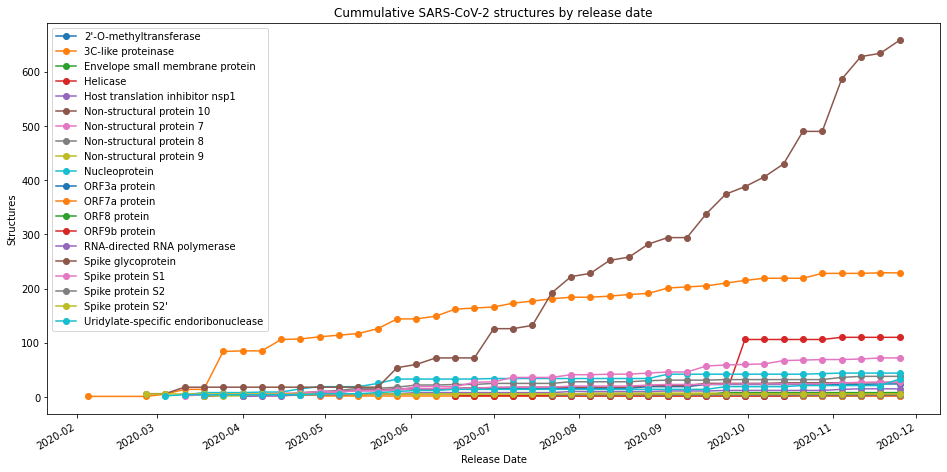

In [18]:
ax = df_date.plot(figsize=(16, 8), x='releaseDate', title=f'Cummulative {pathogen} structures by release date', marker='o');
ax.set_xlabel('Release Date');
ax.set_ylabel('Structures');
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

### Distribution of resolution by protein

In [19]:
query = """
MATCH (p:Protein{taxonomyId:$taxonomy_id})-[t:HAS_TERTIARY_STRUCTURE]->(:Chain)-[:IS_PART_OF_STRUCTURE]->(s:Structure)
WHERE t.coverage > 0.2 AND ('X-RAY DIFFRACTION' IN s.methods OR 'ELECTRON MICROSCOPY' IN s.methods) 
RETURN p.name AS protein, s.resolution AS resolution, s.name, s.methods
ORDER BY protein, resolution
"""
pdbs_by_res = graph.run(query, taxonomy_id=taxonomy_id).to_data_frame()

In [20]:
df_res = pd.DataFrame(pdbs_by_res.pivot(columns='protein', values='resolution').to_records())

In [21]:
df_res.drop_duplicates(inplace=True)

In [22]:
df_res.drop('index', axis=1, inplace=True)

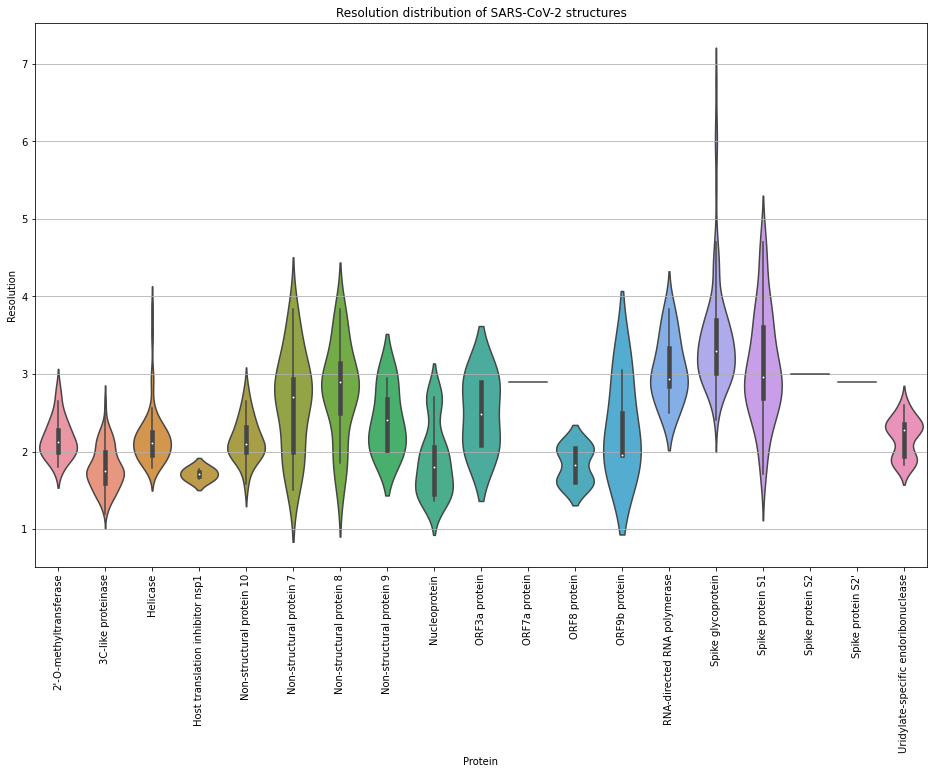

In [23]:
fig, axes = plt.subplots(figsize=(16, 10))
sns.violinplot(data=df_res, scale='width', ax = axes)
#sns.swarmplot(data=df_res, size=3, ax = axes)

axes.set_title(f'Resolution distribution of {pathogen} structures')
axes.yaxis.grid(True)
axes.set_xlabel('Protein')
axes.set_ylabel('Resolution')

plt.xticks(rotation=90)
plt.show()